# 3. 유동/상주/직장인구와 매출 데이터

* 지역별 유동인구의 특성 파악하기 (유동/상주/직장인구 집중 상위 지역 파악)
* 매출 데이터와 상관 관계 파악
* 인구 특성과 매출 시간/요일 집중도 비교

## 4. 3번의 상권별 특성 파악
* 업종별 특성 파악
* 매출, 성별, 연령대 집중도 등

테이블 정리:

3에서 사용되는 테이블
* 지역별 유동인구의 특성 파악: Floating_Population, Area_Type
* 매출데이터와 유동인구의 상관관계 파악: Sales_*, Shop 
* 인구 특성과 매출 시간/요일의 집중도 비교: Floating_Population (pop_type), Sales_Daytype, Sales_Day, Sales_Time
=> 유동/상주/직장인구 탑 지역은 따로 저장 (resident_area, working_area)

4에서 사용되는 테이블
* 유동인구 많은 상위 지역(resident_area, working_area)별로 업종 파악: service_Category
* 유동인구 많은 상위 지역의 매출, 성별, 연령대 집중도: Sales_Sex, Sales_Age, Floating_Population

## 지역별 유동인구(상주/직장) 파악

### DB에서 데이터 가져오기

In [45]:
import mysql.connector
import pandas as pd
import numpy as np

remote = mysql.connector.connect(
    host = "triodb.crgkkewom2kz.ap-northeast-2.rds.amazonaws.com",
    user = "yang",
    password = "trio1234",
    database = "triodb"
)

In [46]:
query = """
SELECT
    c.name,
    p.commercial_area_code,
    p.pop_type,
    SUM(p.population) AS total_pop
FROM 
    Population_GA as p,
    Commercial_Area as c
WHERE
    c.code = p.commercial_area_code
GROUP BY
    p.commercial_area_code,
    p.pop_type
ORDER BY
    total_pop desc,
    p.pop_type;
"""

df = pd.read_sql(query, remote)

remote.close()

df.head()

/tmp/ipykernel_7731/2567771600.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,name,commercial_area_code,pop_type,total_pop
0,명동 남대문 북창동 다동 무교동 관광특구,3001492,WORKING,843479.0
1,여의도역(여의도),3120149,WORKING,539674.0
2,잠실 관광특구,3001495,WORKING,472273.0
3,삼성역,3120222,WORKING,443645.0
4,강남 마이스 관광특구,3001496,WORKING,442640.0


In [47]:
population_df = df

population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  3277 non-null   object 
 1   commercial_area_code  3277 non-null   int64  
 2   pop_type              3277 non-null   object 
 3   total_pop             3277 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 102.5+ KB


In [48]:
population_df.head()

,name,commercial_area_code,pop_type,total_pop
0,명동 남대문 북창동 다동 무교동 관광특구,3001492,WORKING,843479.0
1,여의도역(여의도),3120149,WORKING,539674.0
2,잠실 관광특구,3001495,WORKING,472273.0
3,삼성역,3120222,WORKING,443645.0
4,강남 마이스 관광특구,3001496,WORKING,442640.0


In [49]:
population_df.to_csv("../data/3_1_지역별_유동인구_파악.csv")

### 시각화

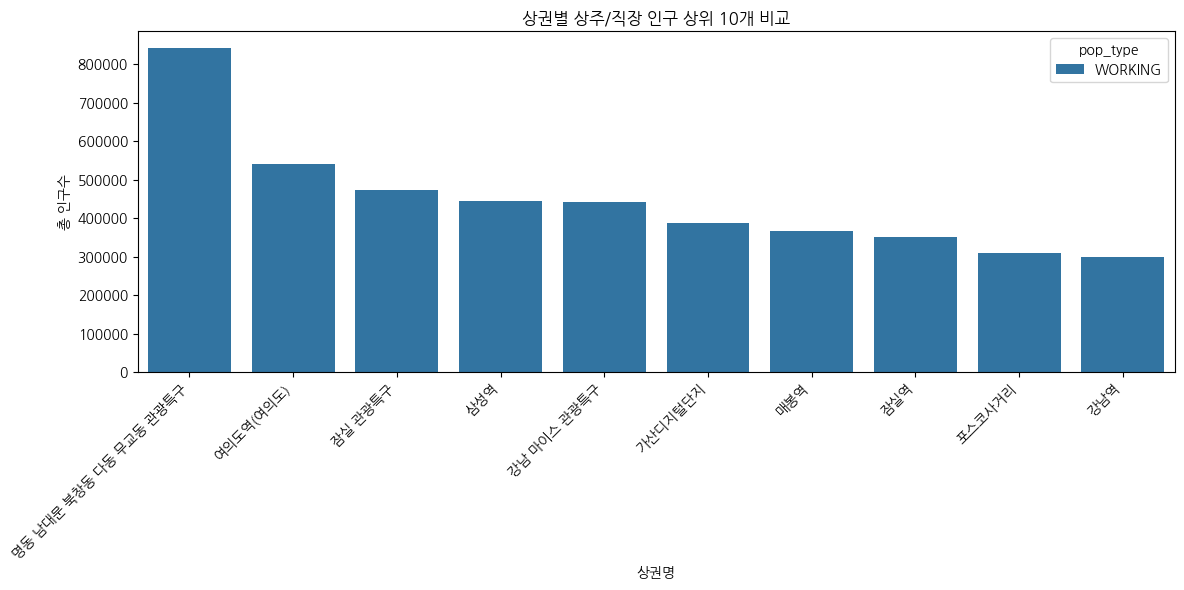

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# total_pop 기준 상위 10개만 추출
top10 = df.nlargest(10, 'total_pop')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    x='name',
    y='total_pop',
    hue='pop_type'
)

plt.title('상권별 상주/직장 인구 상위 10개 비교')
plt.xlabel('상권명')
plt.ylabel('총 인구수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



/tmp/ipykernel_7731/3408676943.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'total_pop'))


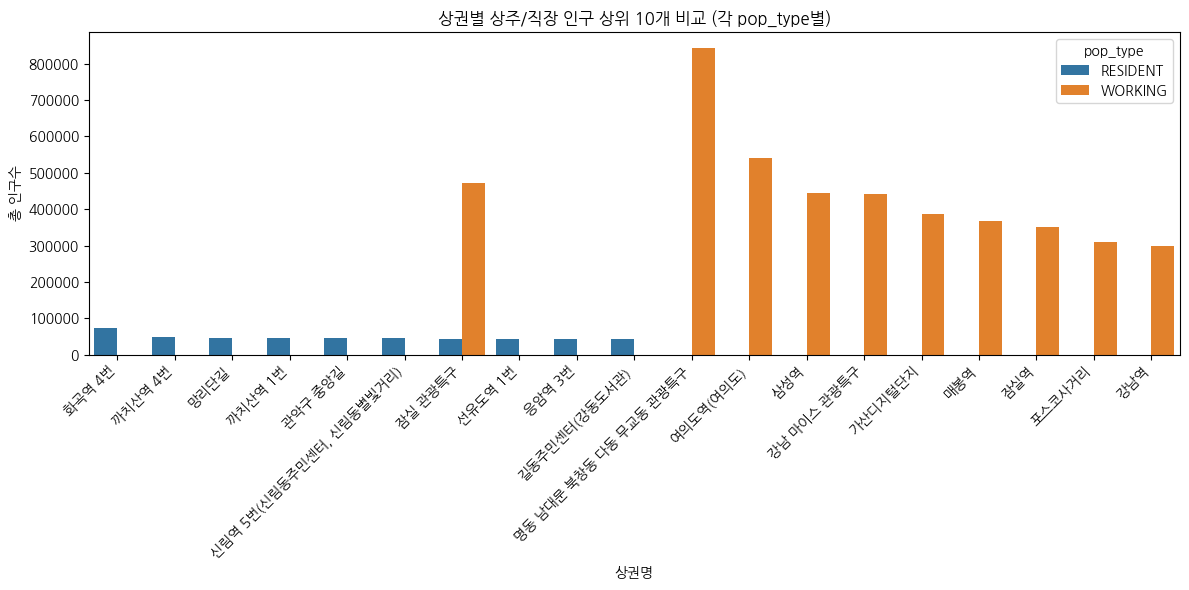

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# pop_type별 상위 10개씩 추출
top10_each = (
    df.groupby('pop_type', group_keys=False)
      .apply(lambda x: x.nlargest(10, 'total_pop'))
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_each,
    x='name',
    y='total_pop',
    hue='pop_type'
)

plt.title('상권별 상주/직장 인구 상위 10개 비교 (각 pop_type별)')
plt.xlabel('상권명')
plt.ylabel('총 인구수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 매출데이터와 유동인구의 상관관계 파악: Sales_*, Shop 

In [5]:

remote.close()


In [ ]:
import mysql.connector
import pandas as pd
import numpy as np



remote = mysql.connector.connect(
    host = "triodb.crgkkewom2kz.ap-northeast-2.rds.amazonaws.com",
    user = "yang",
    password = "trio1234",
    database = "triodb"
)


# 1. 임시 테이블 생성
create_temp_query = """
CREATE TEMPORARY TABLE sales_summary AS
SELECT s.commercial_area_code, SUM(sd.sales) AS total_sales
FROM Sales_Day sd
JOIN Shop_Count s ON sd.store_id = s.id
GROUP BY s.commercial_area_code;
"""
with remote.cursor() as cur:
    cur.execute(create_temp_query)
    remote.commit()  # 임시 테이블 생성 완료

# 2. 실제 데이터 조회
select_query = """
SELECT
    c.name AS commercial_area_name,
    pg.pop_type,
    SUM(pg.population) AS total_population,
    ss.total_sales
FROM sales_summary ss
JOIN Commercial_Area c ON ss.commercial_area_code = c.code
JOIN Population_GA pg ON pg.commercial_area_code = c.code
GROUP BY c.name, pg.pop_type, ss.total_sales
ORDER BY ss.total_sales DESC;
"""

sales_df = pd.read_sql(select_query, remote)

remote.close()


/tmp/ipykernel_13204/629433563.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_df = pd.read_sql(select_query, remote)


In [7]:
sales_df.head()

,commercial_area_name,pop_type,total_population,total_sales
0,노량진역(노량진),RESIDENT,12828.0,4.377254e+12
1,노량진역(노량진),WORKING,18927.0,4.377254e+12
2,가산디지털단지,RESIDENT,22132.0,3.004122e+12
3,가산디지털단지,WORKING,387730.0,3.004122e+12
4,용산전자상가(용산역),RESIDENT,6020.0,2.481580e+12


In [ ]:
sales_df['total_sales'] = sales_df['total_sales'].apply(lambda x: int(x))


In [9]:
sales_df.head()

,commercial_area_name,pop_type,total_population,total_sales
0,노량진역(노량진),RESIDENT,12828.0,4377254155412
1,노량진역(노량진),WORKING,18927.0,4377254155412
2,가산디지털단지,RESIDENT,22132.0,3004121701306
3,가산디지털단지,WORKING,387730.0,3004121701306
4,용산전자상가(용산역),RESIDENT,6020.0,2481580235065


In [10]:
sales_df.to_csv("../data/3_2_매출데이터와_유동인구.csv")

### 시각화

In [16]:
sales_df = pd.read_csv("../data/3_2_매출데이터와_유동인구.csv")

sales_df.tail()

,Unnamed: 0,commercial_area_name,pop_type,total_population,total_sales
3138,3138,신목동역,WORKING,1897.0,2830464
3139,3139,조양시장,RESIDENT,324.0,2433846
3140,3140,조양시장,WORKING,24.0,2433846
3141,3141,인수초등학교,RESIDENT,7036.0,894168
3142,3142,인수초등학교,WORKING,343.0,894168


<Figure size 1200x600 with 0 Axes>

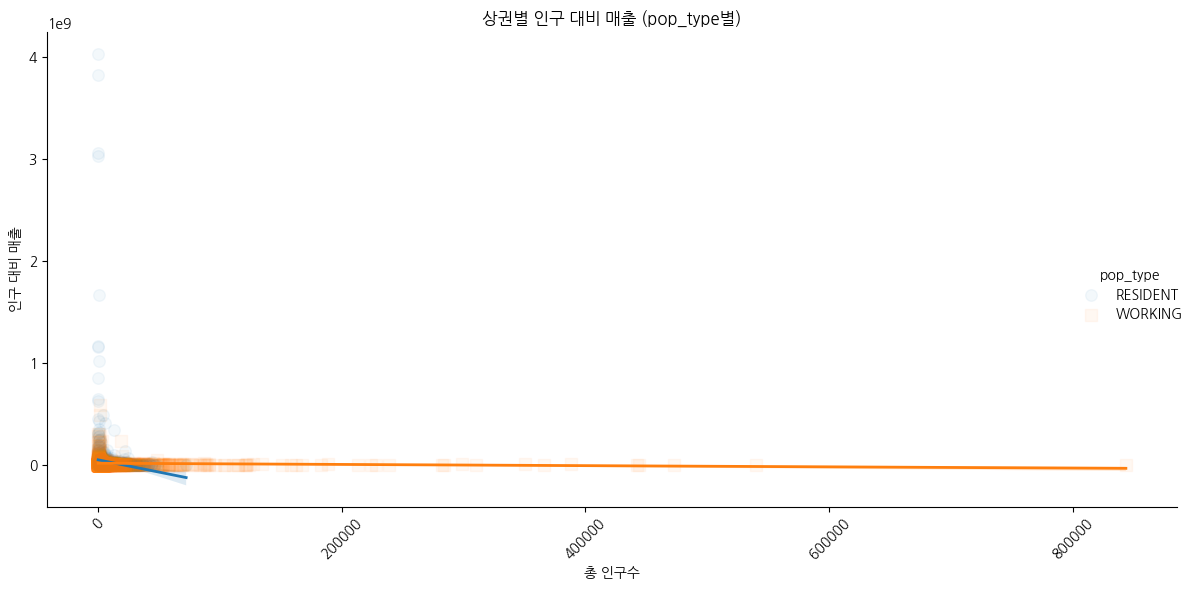

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib


plt.figure(figsize=(12, 6))

# pop_type별 scatter + 회귀선 (log scale)
sns.lmplot(
    data=sales_df,
    x='total_population',
    y='sales_per_capita',
    hue='pop_type',
    height=6,
    aspect=1.8,
    markers=['o', 's'],
    scatter_kws={'s':70, 'alpha':0.05},
    line_kws={'linewidth':2}
)

plt.title('상권별 인구 대비 매출 (pop_type별)')
plt.xlabel('총 인구수')
plt.ylabel('인구 대비 매출')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

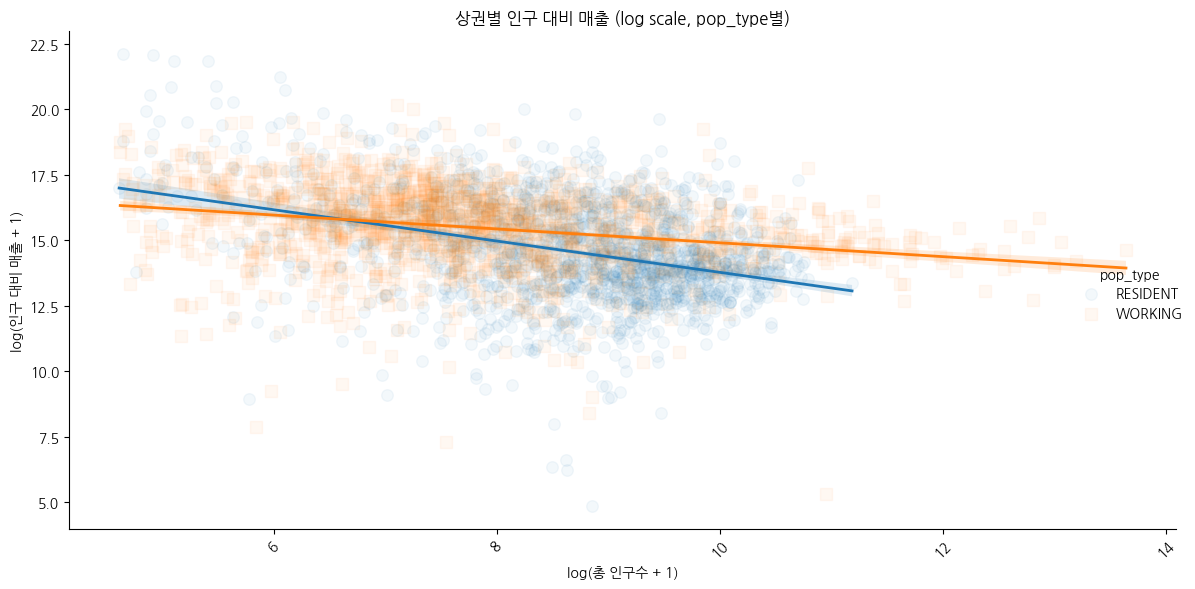

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 0 또는 음수 값 방지 + log 변환
sales_df['log_total_population'] = np.log1p(sales_df['total_population'])
sales_df['log_sales_per_capita'] = np.log1p(sales_df['sales_per_capita'])

plt.figure(figsize=(12, 6))

# pop_type별 scatter + 회귀선 (log scale)
sns.lmplot(
    data=sales_df,
    x='log_total_population',
    y='log_sales_per_capita',
    hue='pop_type',
    height=6,
    aspect=1.8,
    markers=['o', 's'],
    scatter_kws={'s':70, 'alpha':0.05},
    line_kws={'linewidth':2}
)

plt.title('상권별 인구 대비 매출 (log scale, pop_type별)')
plt.xlabel('log(총 인구수 + 1)')
plt.ylabel('log(인구 대비 매출 + 1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 인구 특성과 매출 시간/요일 집중도 비교

## 데이터 정리

In [103]:
import mysql.connector
import pandas as pd
import numpy as np

remote = mysql.connector.connect(
    host = "triodb.crgkkewom2kz.ap-northeast-2.rds.amazonaws.com",
    user = "yang",
    password = "trio1234",
    database = "triodb"
)

select_query = """
    SELECT
        s.commercial_area_code,
        st.time,
        SUM(st.sales) AS total_sales,
        SUM(st.customer_count) AS total_customers
    FROM Sales_Time st
    JOIN Shop_Count s ON st.store_id = s.id
    GROUP BY s.commercial_area_code, st.time
"""

sales_time = pd.read_sql(select_query, remote)

select_query = """
    SELECT
        c.name "commercial_area_name",
        f.commercial_area_code "commercial_area_code",
        SUM(t00_06_pop) t00_06_pop,
        SUM(t06_11_pop) t06_11_pop,
        SUM(t11_14_pop) t11_14_pop,
        SUM(t14_17_pop) t14_17_pop,
        SUM(t17_21_pop) t17_21_pop,
        SUM(t21_24_pop) t21_24_pop
    FROM Floating_Population f
    JOIN Commercial_Area c
    ON f.commercial_area_code = c.code
    GROUP BY commercial_area_code;
"""
pop_time = pd.read_sql(select_query, remote)

remote.close()

print(sales_time.head())

print()
print(pop_time.head())

/tmp/ipykernel_19567/3236356351.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_time = pd.read_sql(select_query, remote)


   commercial_area_code   time  total_sales  total_customers
0               3110001  00-06   38628894.0            619.0
1               3110002  00-06   27846233.0            465.0
2               3110003  00-06  196532663.0           1924.0
3               3110004  00-06    2632163.0             14.0
4               3110005  00-06   68939249.0            632.0

     commercial_area_name  commercial_area_code  t00_06_pop  t06_11_pop  \
0                이태원 관광특구               3001491   1895592.0   1460863.0   
1  명동 남대문 북창동 다동 무교동 관광특구               3001492   1525029.0   5965730.0   
2            동대문패션타운 관광특구               3001493   2522709.0   2738662.0   
3              종로·청계 관광특구               3001494   3579057.0   6542641.0   
4                 잠실 관광특구               3001495   2913751.0   2987818.0   

   t11_14_pop  t14_17_pop  t17_21_pop  t21_24_pop  
0   1166166.0   1253333.0   1686675.0   1108133.0  
1   7113146.0   7038391.0   5493145.0   1419882.0  
2   2149149.0   2165234.0 

/tmp/ipykernel_19567/3236356351.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pop_time = pd.read_sql(select_query, remote)


In [80]:
import re

pop_time_melted = pop_time.melt(
    id_vars=['commercial_area_name', 'commercial_area_code'],
    value_vars=['t00_06_pop','t06_11_pop','t11_14_pop','t14_17_pop','t17_21_pop','t21_24_pop'],
    var_name='time',
    value_name='floating_population'
)
cleaned_times = []
pattern = re.compile(r'^t(\d{2})_(\d{2})_pop$')

# pop_time_melted['time']를 리스트로 변환 후 처리
for t in pop_time_melted['time']:
    cleaned_times.append(pattern.sub(r'\1-\2', t))

# 다시 DataFrame에 넣기
pop_time_melted['time'] = cleaned_times

pop_time_melted.head()

,commercial_area_name,commercial_area_code,time,floating_population
0,이태원 관광특구,3001491,00-06,1895592.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,00-06,1525029.0
2,동대문패션타운 관광특구,3001493,00-06,2522709.0
3,종로·청계 관광특구,3001494,00-06,3579057.0
4,잠실 관광특구,3001495,00-06,2913751.0


In [81]:
merged = pd.merge(
    pop_time_melted,
    sales_time,  # Sales_Time 상권 단위 집계
    on=['commercial_area_code','time'],
    how='inner'  # 상권/시간대가 일치하는 것만
)

merged.head()

,commercial_area_name,commercial_area_code,time,floating_population,total_sales,total_customers
0,이태원 관광특구,3001491,00-06,1895592.0,5.458610e+10,2507710.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,00-06,1525029.0,3.980736e+10,566321.0
2,동대문패션타운 관광특구,3001493,00-06,2522709.0,2.257012e+10,1155247.0
3,종로·청계 관광특구,3001494,00-06,3579057.0,2.070253e+10,630591.0
4,잠실 관광특구,3001495,00-06,2913751.0,4.133050e+10,1208067.0


In [82]:
merged["total_sales"] = merged  ["total_sales"].astype(int)

In [83]:
merged.head()

,commercial_area_name,commercial_area_code,time,floating_population,total_sales,total_customers
0,이태원 관광특구,3001491,00-06,1895592.0,54586098370,2507710.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,00-06,1525029.0,39807364910,566321.0
2,동대문패션타운 관광특구,3001493,00-06,2522709.0,22570120393,1155247.0
3,종로·청계 관광특구,3001494,00-06,3579057.0,20702533011,630591.0
4,잠실 관광특구,3001495,00-06,2913751.0,41330500024,1208067.0


In [84]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9480 entries, 0 to 9479
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   commercial_area_name  9480 non-null   object 
 1   commercial_area_code  9480 non-null   int64  
 2   time                  9480 non-null   object 
 3   floating_population   9480 non-null   float64
 4   total_sales           9480 non-null   int64  
 5   total_customers       9480 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 444.5+ KB


In [85]:
merged.to_csv("../data/3_3_시간별_매출.csv")

In [89]:
import mysql.connector
import pandas as pd
import numpy as np

remote = mysql.connector.connect(
    host = "triodb.crgkkewom2kz.ap-northeast-2.rds.amazonaws.com",
    user = "yang",
    password = "trio1234",
    database = "triodb"
)

select_query = """
    SELECT
        s.commercial_area_code,
        sd.week,
        SUM(sd.sales) AS total_sales,
        SUM(sd.customer_count) AS total_customers
    FROM Sales_Day sd
    JOIN Shop_Count s ON sd.store_id = s.id
    GROUP BY s.commercial_area_code, sd.week
"""

sales_day = pd.read_sql(select_query, remote)

select_query = """
    SELECT
        c.name "commercial_area_name",
        f.commercial_area_code "commercial_area_code",
        SUM(mon_pop) MONDAY,
        SUM(tue_pop) TUESDAY,
        SUM(wed_pop) WEDNESDAY,
        SUM(thu_pop) THURSDAY,
        SUM(fri_pop) FRIDAY,
        SUM(sat_pop) SATURDAY,
        SUM(sun_pop) SUNDAY
    FROM Floating_Population f
    JOIN Commercial_Area c
    ON f.commercial_area_code = c.code
    GROUP BY commercial_area_code;
"""
pop_day = pd.read_sql(select_query, remote)

remote.close()

print(sales_day.head())

print()
print(pop_day.head())


/tmp/ipykernel_19567/764972128.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_day = pd.read_sql(select_query, remote)


   commercial_area_code    week   total_sales  total_customers
0               3110001  MONDAY  2.306369e+08           6520.0
1               3110002  MONDAY  4.203081e+09         152533.0
2               3110003  MONDAY  9.855501e+08          17178.0
3               3110004  MONDAY  1.985533e+08           4560.0
4               3110005  MONDAY  5.912225e+08           3253.0

     commercial_area_name  commercial_area_code     MONDAY    TUESDAY  \
0                이태원 관광특구               3001491  1107090.0  1095019.0   
1  명동 남대문 북창동 다동 무교동 관광특구               3001492  4452014.0  4688168.0   
2            동대문패션타운 관광특구               3001493  2109758.0  2161497.0   
3              종로·청계 관광특구               3001494  5118959.0  5293404.0   
4                 잠실 관광특구               3001495  2268059.0  2304198.0   

   WEDNESDAY   THURSDAY     FRIDAY   SATURDAY     SUNDAY  
0  1145792.0  1144569.0  1259463.0  1473414.0  1345410.0  
1  4650240.0  4689190.0  4680198.0  3006040.0  2389477.0  
2  21

/tmp/ipykernel_19567/764972128.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pop_day = pd.read_sql(select_query, remote)


In [90]:
pop_day_melted = pop_day.melt(
    id_vars=['commercial_area_name', 'commercial_area_code'],
    value_vars=['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY', 'SUNDAY'],
    var_name='week',
    value_name='floating_population'
)

pop_day_melted.head()

,commercial_area_name,commercial_area_code,week,floating_population
0,이태원 관광특구,3001491,MONDAY,1107090.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,MONDAY,4452014.0
2,동대문패션타운 관광특구,3001493,MONDAY,2109758.0
3,종로·청계 관광특구,3001494,MONDAY,5118959.0
4,잠실 관광특구,3001495,MONDAY,2268059.0


In [92]:
merged = pd.merge(
    pop_day_melted,
    sales_day,
    on=['commercial_area_code','week'],
    how='inner'
)

merged.head()

,commercial_area_name,commercial_area_code,week,floating_population,total_sales,total_customers
0,이태원 관광특구,3001491,MONDAY,1107090.0,3.550932e+10,1340223.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,MONDAY,4452014.0,2.763080e+11,9831998.0
2,동대문패션타운 관광특구,3001493,MONDAY,2109758.0,6.630981e+10,2017118.0
3,종로·청계 관광특구,3001494,MONDAY,5118959.0,1.554046e+11,3914396.0
4,잠실 관광특구,3001495,MONDAY,2268059.0,1.702945e+11,6174815.0


In [95]:
merged['total_sales'] = merged['total_sales'].astype(int)

In [96]:
merged.head()

,commercial_area_name,commercial_area_code,week,floating_population,total_sales,total_customers
0,이태원 관광특구,3001491,MONDAY,1107090.0,35509321731,1340223.0
1,명동 남대문 북창동 다동 무교동 관광특구,3001492,MONDAY,4452014.0,276307999078,9831998.0
2,동대문패션타운 관광특구,3001493,MONDAY,2109758.0,66309807274,2017118.0
3,종로·청계 관광특구,3001494,MONDAY,5118959.0,155404637432,3914396.0
4,잠실 관광특구,3001495,MONDAY,2268059.0,170294512346,6174815.0


In [97]:
sales_time.to_csv("../data/3_3_요일별_매출.csv")

### 시각화

In [98]:
import pandas as pd

sales_time = pd.read_csv("../data/3_3_시간별_매출.csv")
sales_time.head()

,Unnamed: 0,commercial_area_name,commercial_area_code,time,floating_population,total_sales,total_customers
0,0,이태원 관광특구,3001491,00-06,1895592.0,54586098370,2507710.0
1,1,명동 남대문 북창동 다동 무교동 관광특구,3001492,00-06,1525029.0,39807364910,566321.0
2,2,동대문패션타운 관광특구,3001493,00-06,2522709.0,22570120393,1155247.0
3,3,종로·청계 관광특구,3001494,00-06,3579057.0,20702533011,630591.0
4,4,잠실 관광특구,3001495,00-06,2913751.0,41330500024,1208067.0


KeyError: 'pop_type'

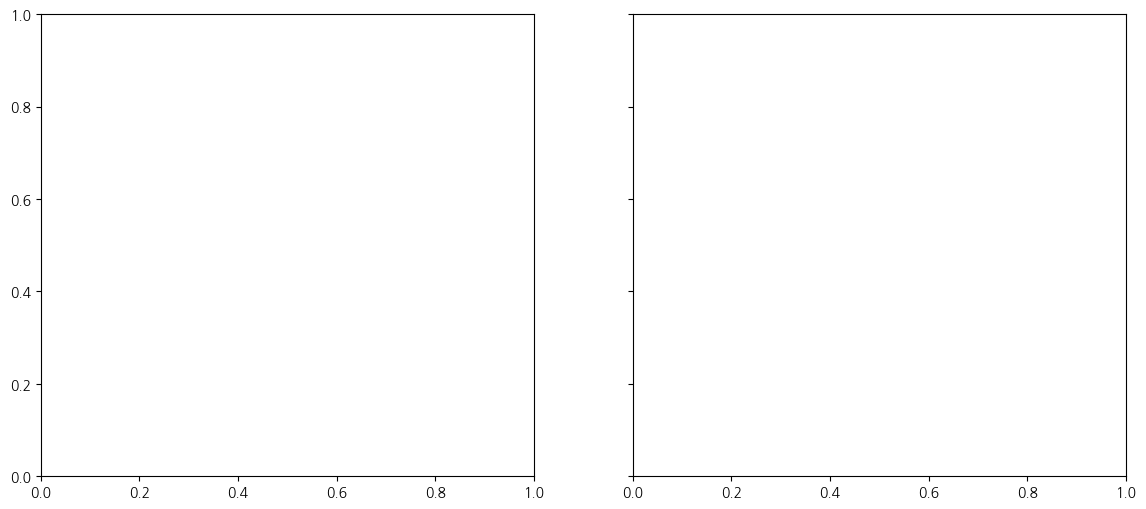

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 상위 5개 상권만 예시
top_areas = sales_time.groupby('commercial_area_name')['total_sales'].sum().nlargest(5).index
df_top = sales_time[sales_time['commercial_area_name'].isin(top_areas)]

pop_types = ['RESIDENT', 'WORKING']  # 순서 고정
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for i, pop in enumerate(pop_types):
    df_pop = df_top[df_top['pop_type'] == pop]  # 여기서 필터링
    sns.lineplot(
        data=df_pop,
        x='time',
        y='total_population',
        hue='commercial_area_name',
        marker='o',
        dashes=False,
        ax=axes[i]
    )
    axes[i].set_title(f"Pop Type: {pop}")
    axes[i].set_xlabel("시간대")
    axes[i].set_ylabel("총 매출" if i == 0 else "")
    axes[i].legend().set_title("상권")

plt.tight_layout()
plt.show()

In [21]:
print(df_top[df_top['pop_type'] == 'RESIDENT'].head())
print(df_top[df_top['pop_type'] == 'WORKING'].head())

    Unnamed: 0         commercial_name  pop_type   time  sales_by_time  \
13          13  명동 남대문 북창동 다동 무교동 관광특구  RESIDENT  00-06    39807364910   
15          15  명동 남대문 북창동 다동 무교동 관광특구  RESIDENT  06-11   189431609040   
17          17  명동 남대문 북창동 다동 무교동 관광특구  RESIDENT  11-14   616122805667   
19          19  명동 남대문 북창동 다동 무교동 관광특구  RESIDENT  14-17   485915908597   
21          21  명동 남대문 북창동 다동 무교동 관광특구  RESIDENT  17-21   428303539061   

    customers_by_time  total_population  sales_per_pop  
13           566321.0            3808.0   1.045361e+07  
15         11203874.0            3808.0   4.974570e+07  
17         21767607.0            3808.0   1.617970e+08  
19         13521404.0            3808.0   1.276040e+08  
21         11569323.0            3808.0   1.124747e+08  
    Unnamed: 0         commercial_name pop_type   time  sales_by_time  \
12          12  명동 남대문 북창동 다동 무교동 관광특구  WORKING  00-06    39807364910   
14          14  명동 남대문 북창동 다동 무교동 관광특구  WORKING  06-11   1894316090

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상위 6개 상권만 예시
top_areas = sales_time.groupby('commercial_name')['sales_by_time'].sum().nlargest(6).index
df_top = sales_time[sales_time['commercial_name'].isin(top_areas)]

g = sns.FacetGrid(df_top, col="commercial_name", hue="pop_type", col_wrap=3, height=4)
g.map(sns.lineplot, "time", "sales_by_time", marker="o")
g.add_legend()
g.set_axis_labels("시간대", "총 매출")
g.set_titles(col_template="{col_name}")
plt.show()


KeyError: 'commercial_name'